Enter your name: Judhajit Roy


In [ ]:
# All imports
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from torch import distributions
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fashion MNIST Dataset

import torchvision.transforms as transforms
from torchvision import datasets

# Transformations as per tensorflow 
transform = transforms.Compose([
        transforms.Lambda(lambda x: np.round(np.array(x)/27).astype(int)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x))
    ])

xtrain = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=transform
    )

xtest = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

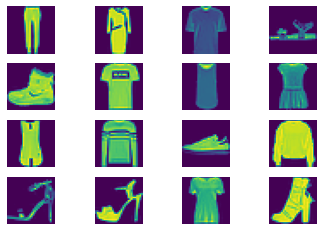

In [ ]:
def draw_grid(imlist, m, n):
  fig, grid = plt.subplots(m,n) 
  for i in range(m):
    for j in range(n):
      grid[i,j].axis('off')
      grid[i,j].imshow(np.reshape(imlist[(i-1)*m+j], (28,28)))
    
draw_grid((xtrain.data).detach().numpy(), 4,4)

In [ ]:
# NADE implementation

class NADE(nn.Module):

    def __init__(self, in_dim, hid_dim):

        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim

        # Parameters required
        self.in_W = nn.Parameter(torch.zeros(hid_dim, self.in_dim)) #initial weight
        self.in_b = nn.Parameter(torch.zeros(hid_dim)) 
        self.h_W = nn.Parameter(torch.zeros(self.in_dim, hid_dim)) #hidden unit parameters
        self.h_b = nn.Parameter(torch.zeros(self.in_dim,10))
        
        self.hiddenlayer = nn.Linear(10, 10) #(input,hidden)

        # initializing weights using kaiming normalization for non-linearity
        nn.init.kaiming_normal_(self.in_W)
        nn.init.kaiming_normal_(self.h_W)

    def forward_pass(self, x, get_sample=False):

        # Calculating forward pass!

        xhat,xsample = [],[]
        a = self.in_b.expand(batch_size, -1)

        # For sampling
        if get_sample:
          a = self.in_b.expand(1, -1)

        for i in range(self.in_dim):

            # Hidden state
            h = torch.relu(a)
            # hi = torch.sigmoid(h @ self.h_W[i : i + 1, :].t() + self.h_b[i : i + 1])

            hi1 = h @ self.h_W[i : i + 1, :].t() + self.h_b[i : i + 1]
            # print(hi1.shape)
            hi2 = self.hiddenlayer(hi1) # added hidden layer to increase complexity
            # print(hi2.shape)

            # Calculate probability
            # pi = torch.log_softmax(h @ self.h_W[i : i + 1, :].t() + self.h_b[i : i + 1],1)
            pi = torch.log_softmax(hi2,1)
            # storing logits of current pixel
            xhat.append(pi.unsqueeze(dim=2))
            
            if get_sample:

                # Sampling a pixel value from categorical distribution
                x = torch.distributions.Categorical(logits=torch.reshape(pi,(10,))).sample()
                xsample.append(torch.reshape(x,(1,1)))
                # a = a + torch.reshape(x,(1,1)).type(torch.cuda.FloatTensor) @ self.in_W[:, i : i + 1].t()
                a = a + torch.reshape(x,(1,1)).type(torch.FloatTensor) @ self.in_W[:, i : i + 1].t()

            else:

                # Update with all pixels value till current
                xi = x[:, i : i + 1]
                a = a + xi @ self.in_W[:, i : i + 1].t()   

        if get_sample:
            # return sample (784 pixels)
            xsample = torch.cat(xsample, 1)
            return  xsample

        return torch.cat(xhat, 2)

    def forward(self, x):

        return self.forward_pass(x)

    def sample(self):

        xs = self.forward_pass(x=None,get_sample=True)
        return xs    

In [ ]:
def train(train_loader, loss_function, optimizer, model, device):
    model.train()
    train_loss = 0
    for i, (imgs,imgtype) in enumerate(train_loader):
        optimizer.zero_grad()

        inputs = imgs.type(torch.FloatTensor)
        # inputs = imgs.type(torch.cuda.FloatTensor)
        # print(inputs.shape)
        x_hat = model(inputs)

        # loss = loss_function(x_hat, imgs.type(torch.cuda.LongTensor))/imgs.size(0)
        loss = loss_function(x_hat, imgs.type(torch.LongTensor))/imgs.size(0)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()

        # record
        
        if i % 100 == 0:
          print("loss for batch",i,":",np.round(loss.item(),3))
    # print("Average loss:",train_loss.append(loss.item()))        
    return train_loss/(60000/imgs.size(0))

def grab_sample(model):

    # grab sample from model trained for nth epoch
    model.eval()
    xs = model.sample()
    # print(xs)
    plt.imshow(xs.cpu().detach().squeeze().view(28, 28).numpy())

    plt.show()  

def grab_sample_tensor(model):

    # grab sample from model trained for nth epoch
    model.eval()
    xs = model.sample()
    # print(xs)
    return xs       

def testing(test_loader, loss_function, model, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (imgs,imgtype) in enumerate(test_loader):
        # for (imgs, _) in test_loader:
            x_hat = model(imgs.type(torch.FloatTensor))
            loss = loss_function(x_hat, imgs.type(torch.LongTensor))/imgs.size(0)
            # loss = loss_function(x_hat, imgs.type(torch.cuda.LongTensor))/imgs.size(0)
            test_loss += loss.item()
        print("test loss :",np.round(loss.item(),3))
    return test_loss/(10000/imgs.size(0))

Running Epoch 1
loss for batch 0 : 2707.801
loss for batch 100 : 845.29
loss for batch 200 : 784.514
loss for batch 300 : 774.098
loss for batch 400 : 776.236
loss for batch 500 : 751.577
test loss : 753.917


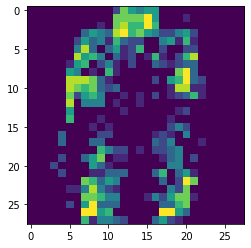

Running Epoch 2
loss for batch 0 : 724.769
loss for batch 100 : 724.098
loss for batch 200 : 718.866
loss for batch 300 : 692.137
loss for batch 400 : 680.28
loss for batch 500 : 716.921
test loss : 724.28


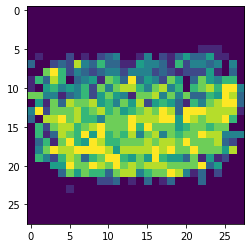

Running Epoch 3
loss for batch 0 : 697.896
loss for batch 100 : 693.056
loss for batch 200 : 708.757
loss for batch 300 : 704.092
loss for batch 400 : 669.689
loss for batch 500 : 669.913
test loss : 709.227


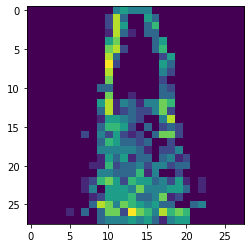

In [ ]:
# Run training!
data_path = "data"
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 3
batch_size = 100

train_loader = torch.utils.data.DataLoader(xtrain, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(xtest, batch_size=batch_size, shuffle=False)

model = NADE(in_dim=784, hid_dim=500).to(device)
loss_function = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(),lr=0.01)
# scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1,verbose=True)

# start training
train_losses = []
test_losses= []
for e in range(epochs):
    print("Running Epoch",e+1)

    train_loss = train(train_loader, loss_function, optimizer, model, device)
    test_loss = testing(test_loader, loss_function,  model, device) 
    # scheduler.step()

    # grabbing one sample to show improvement
    grab_sample(model)

    # record
    train_losses.append(train_loss)
    test_losses.append(test_loss)

torch.save(model.state_dict(), "nadeneuralmodel.pt")  

In [ ]:
torch.save(model.state_dict(), "nadeneuralmodel.pt")    

In [ ]:
model = NADE(in_dim=784, hid_dim=500).to(device)
model.load_state_dict(torch.load("/content/nadeneuralmodel.pt"))


<All keys matched successfully>

Text(0, 0.5, 'Negative Log Likelihood loss')

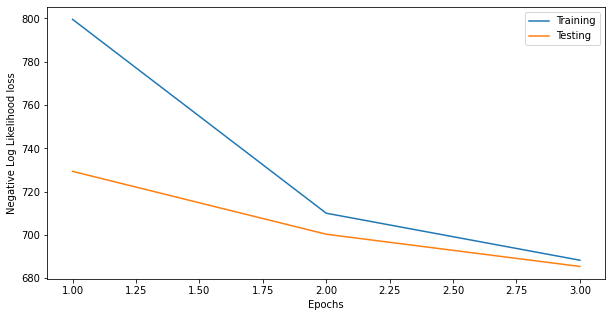

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(x=range(1,epochs+1), y=train_losses)
sns.lineplot(x=range(1,epochs+1), y=test_losses)
plt.legend(labels=['Training', 'Testing'])
plt.xlabel("Epochs")
plt.ylabel("Negative Log Likelihood loss")

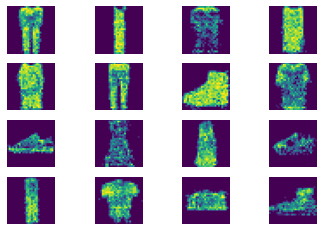

In [ ]:
# 16 samples
def draw_grid(imlist, m, n):
  fig, grid = plt.subplots(m,n) 
  for i in range(m):
    for j in range(n):
      grid[i,j].axis('off')
      grid[i,j].imshow(np.reshape(imlist[(i-1)*m+j], (28,28)))

g = []
for i in range(16):
  g.append(grab_sample_tensor(model).cpu())

draw_grid(g, 4,4)

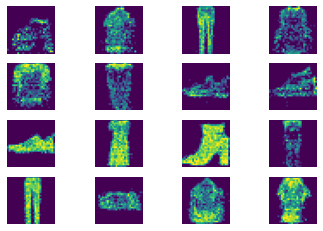

In [ ]:
g2 = []
for i in range(16):
  g2.append(grab_sample_tensor(model))

draw_grid(g2, 4,4)